In [1]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle

from collections import Counter
from shutil import copyfile
from PIL import Image
from IPython import display 

%matplotlib inline

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def is_back_and_white(img):
    a = np.array_equiv(image[:, :, 0], image[:, :, 1])
    b = np.array_equiv(image[:, :, 1], image[:, :, 2])
    return (a and b)

def boost_contrast(img):
    mini = img.min()
    maxi = img.max()
    return (img-mini)*(255/(maxi-mini))

def add_seuillage(img, level=100):
    img = (img-level)*(255/(255-(2*level)))
    img = np.clip(img, 0, 255)
    return img

def prepare_image_final(image):
    if not is_back_and_white(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=50)
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if gray.mean() > 150:
            gray = cv2.bitwise_not(gray)
        gray = boost_contrast(gray)
        gray = add_seuillage(gray, level=0)
    return gray

def compute_IoU(pred, mask, trigger=0.999):
    pred = (pred>trigger)
    mask = (mask>0.9)
    union = np.logical_or(pred, mask)
    intersection = np.logical_and(pred, mask)
    return intersection.sum()/union.sum()

# Model

For this model, we will just use a threshold on the prepared images. If a pixel is above a certain value, it's 1 or 0. We will move the threshold and measure the IoU score with all scores as per Kaggle's info. As there is no training, we can directly apply the evaluation on the full dataset.

In [3]:
steps = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
y = []
for t in range(0, 190, 5):
    score = {x:[] for x in steps}
    for img in glob.glob("images/prepared/train/images/*.png"):
        img_name = os.path.basename(img)
        mask_path = os.path.join("images/prepared/train", "masks", img_name)
        image = cv2.imread(img)
        mask = cv2.imread(mask_path)

        ret1,th1 = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
        iou = compute_IoU(th1, mask)
        for step in steps:
            if iou > step:
                score[step].append(1)
            else:
                score[step].append(0)
    new_score = {key:sum(value)/len(value) for key, value in score.items()}
    result = sum(new_score.values())/len(new_score.values())
    y.append(result)
    print(t, result)

0 0.053432835820895516
5 0.07820895522388058
10 0.178955223880597
15 0.3092537313432836
20 0.43582089552238806
25 0.5220895522388059
30 0.5780597014925374
35 0.5992537313432835
40 0.6020895522388059
45 0.5870149253731344
50 0.5635820895522387
55 0.5340298507462686
60 0.4988059701492539
65 0.4598507462686568
70 0.4200000000000001
75 0.3794029850746269
80 0.34298507462686567
85 0.30208955223880596
90 0.2653731343283582
95 0.23119402985074627
100 0.20119402985074625
105 0.1740298507462687
110 0.14686567164179104
115 0.12373134328358208
120 0.10298507462686568
125 0.08208955223880596
130 0.06597014925373133
135 0.04805970149253731
140 0.03641791044776118
145 0.026716417910447758
150 0.01940298507462686
155 0.014626865671641792
160 0.010746268656716417
165 0.007611940298507464
170 0.0053731343283582094
175 0.004029850746268656
180 0.002985074626865672
185 0.0013432835820895521


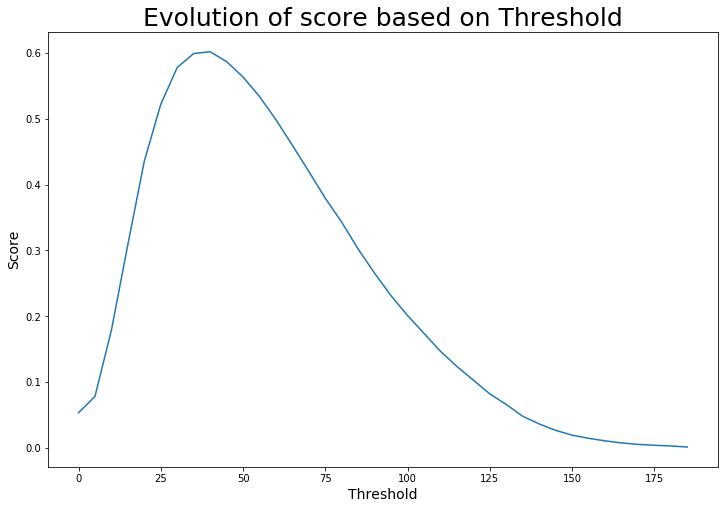

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(list(range(0, 190, 5)), y)
plt.title("Evolution of score based on Threshold", fontsize="25")
plt.xlabel("Threshold", fontsize="14")
plt.ylabel("Score", fontsize="14")
plt.savefig("img/score_simple.png")
plt.show()

Except with low threshold, we have very low score. Just to compare, we can see the predicted mask with a given  threshold.

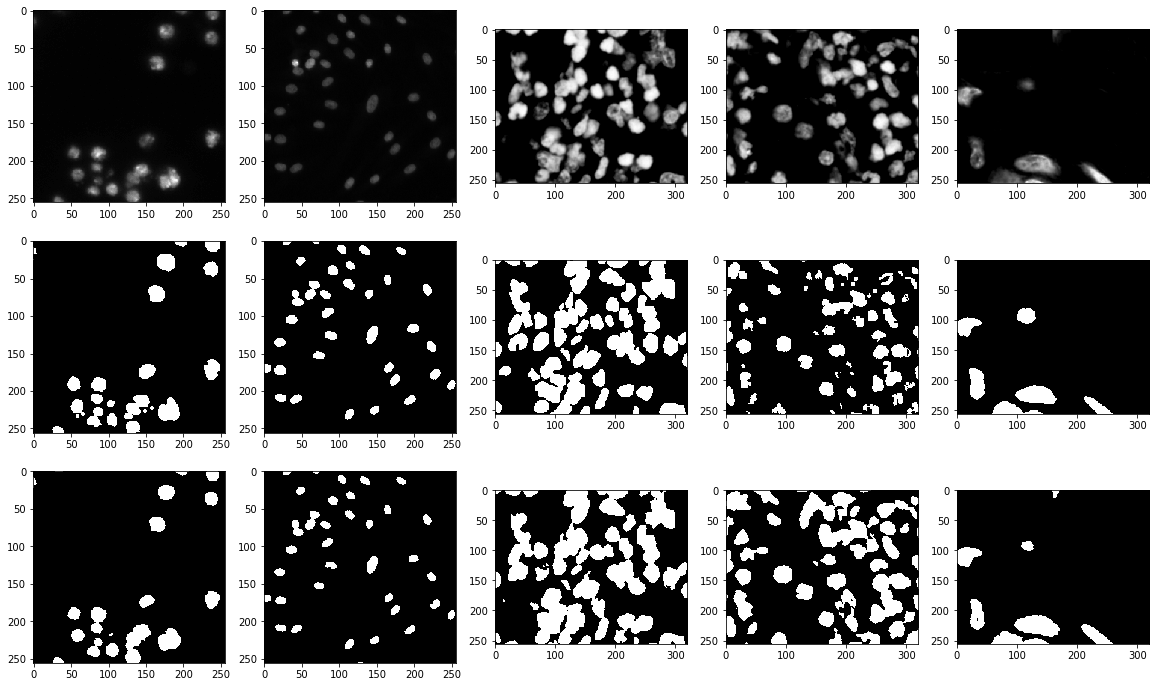

In [7]:
size = 5
t = 40
f, axarr = plt.subplots(3, size, figsize=(20,12))
for idx, img in enumerate(glob.glob("images/prepared/train/images/*.png")[:size]):
    img_name = os.path.basename(img)
    mask_path = os.path.join("images/prepared/train", "masks", img_name)
    image = cv2.imread(img)
    mask = cv2.imread(mask_path)
    ret1,th1 = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
    axarr[0, idx].imshow(image, cmap='gray')
    axarr[1, idx].imshow(mask, cmap='gray')
    axarr[2, idx].imshow(th1, cmap='gray')
plt.savefig("img/result_classique.png")
plt.show()

It's not so bad, just to try, we can fine tune the threshold between 35 and 45

In [26]:
steps = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for t in range(35, 45):
    score = {x:[] for x in steps}
    for img in glob.glob("images/prepared/train/images/*.png"):
        img_name = os.path.basename(img)
        mask_path = os.path.join("images/prepared/train", "masks", img_name)
        image = cv2.imread(img)
        mask = cv2.imread(mask_path)

        ret1,th1 = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
        iou = compute_IoU(th1, mask)
        for step in steps:
            if iou > step:
                score[step].append(1)
            else:
                score[step].append(0)
    new_score = {key:sum(value)/len(value) for key, value in score.items()}
    result = sum(new_score.values())/len(new_score.values())
    print(t, result)

35 0.5992537313432835
36 0.6
37 0.6002985074626865
38 0.5994029850746267
39 0.6016417910447761
40 0.6020895522388059
41 0.5995522388059702
42 0.5982089552238807
43 0.5952238805970148
44 0.5919402985074627


40 seems to be the best threshold. We will use this threshold to do prediction on test set for Kaggle compettion using this setup